In [1]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def evaluate(col, score_df, answer=False):
    if answer:
        res = "answer"
    else:
        res = "result"
    def f1(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].fmeasure
    def rc(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].recall
    def pre(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].precision
    score_df[f'{col}_f1'] = score_df.apply(f1, axis=1)
    score_df[f'{col}_rc'] = score_df.apply(rc, axis=1)
    score_df[f'{col}_pre'] = score_df.apply(pre, axis=1)

Long memory score

In [22]:
import pandas as pd

number = 100
answer_df = pd.read_json("MSC_eval.json", lines=True)
# answer_df = pd.read_json("MSC_score_v1.json", lines=True)
score_df = answer_df[:number]

In [23]:
answer=False
evaluate('long_mem', score_df, answer=answer)
evaluate('long_mem_recall', score_df, answer=answer)
long_mem_means = score_df[['long_mem_f1', 'long_mem_rc', 'long_mem_pre']].mean()
long_mem_recall_means = score_df[['long_mem_recall_f1', 'long_mem_recall_rc', 'long_mem_recall_pre']].mean()
print(long_mem_means)
print(long_mem_recall_means)

/tmp/ipykernel_3416764/3913764922.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df[f'{col}_f1'] = score_df.apply(f1, axis=1)
/tmp/ipykernel_3416764/3913764922.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df[f'{col}_rc'] = score_df.apply(rc, axis=1)


long_mem_f1     0.018045
long_mem_rc     0.657073
long_mem_pre    0.009232
dtype: float64
long_mem_recall_f1     0.039483
long_mem_recall_rc     0.683672
long_mem_recall_pre    0.020760
dtype: float64


/tmp/ipykernel_3416764/3913764922.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df[f'{col}_pre'] = score_df.apply(pre, axis=1)


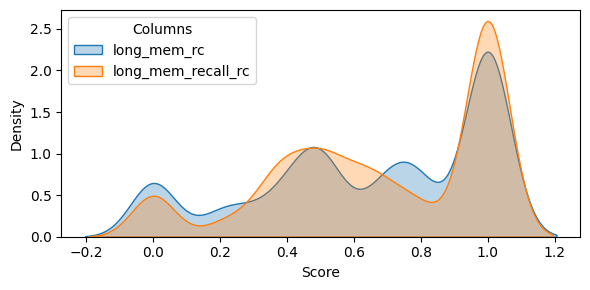

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['long_mem_rc', 'long_mem_recall_rc']

plt.figure(figsize=(6, 3))

for i, column in enumerate(columns):
    data = score_df[column]
    sns.kdeplot(data, label=column, fill=True, alpha=0.3, bw_adjust=0.5)
    
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend(title="Columns")
plt.tight_layout()
plt.show()


In [ ]:
score_df[score_df['long_mem_recall_rc']<=0.5].index

In [25]:
score_df.to_json("MSC_score_0211.json", orient='records', lines=True)

Short memory score

In [6]:
import pandas as pd

number = 500
answer_df = pd.read_json("s_MSC_eval.json", lines=True)
# answer_df = pd.read_json("s_MSC_score_v1.json", lines=True)
score_df = answer_df[:number]
evaluate('short_mem', score_df)

In [7]:
short_mem_means = score_df[['short_mem_f1', 'short_mem_rc', 'short_mem_pre']].mean()
print(short_mem_means)

short_mem_f1     0.031469
short_mem_rc     0.826127
short_mem_pre    0.016256
dtype: float64


In [77]:
score_df.to_json("s_MSC_score.json", orient='records', lines=True)

LLM judge

In [26]:
from dotenv import load_dotenv
from openai import OpenAI
import os

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def llm_create(prompt):
        messages = [{"role": "user", "content": prompt}]
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        return completion.choices[0].message.content

judge_prompt = """Your task is to label an answer to a question as ‘CORRECT’ or ‘WRONG’.

You will be given the following data:

A question (posed by one user to another user).
A ‘gold’ (ground truth) answer.
A generated answer, which you will score as CORRECT/WRONG.
The point of the question is to ask about something one user should know about the other user based on their prior conversations.

The gold answer will usually be a concise and short answer that includes the referenced topic. For example:
Question: Do you remember what I got the last time I went to Hawaii?
Gold answer: A shell necklace

The generated answer might be much longer, but you should be generous with your grading—as long as it touches on the same topic as the gold answer, it should be counted as CORRECT.

For example, the following answers would be considered CORRECT:

Generated answer (CORRECT): Oh yeah, that was so fun! I got so much stuff there, including that shell necklace.
Generated answer (CORRECT): I got a ton of stuff... that surfboard, the mug, the necklace, those coasters too.
Generated answer (CORRECT): That cute necklace.
The following answers would be considered WRONG:

Generated answer (WRONG): Oh yeah, that was so fun! I got so much stuff there, including that mug.
Generated answer (WRONG): I got a ton of stuff... that surfboard, the mug, those coasters too.
Generated answer (WRONG): I’m sorry, I don’t remember what you’re talking about.
Now it’s time for the real question:
Question: {question}
Gold answer: {gold_answer}
Generated answer: {generated_answer}

First, provide a short (one sentence) explanation of your reasoning, then finish with CORRECT or WRONG.

Do NOT include both CORRECT and WRONG in your response, or it will break the evaluation script."""

In [27]:
number = 100
answer_df = pd.read_json("MSC_score_0211.json", lines=True)
score_df = answer_df[:number]

In [28]:
for i in range(number):
    row = score_df.iloc[i]
    p = judge_prompt.format(question=row['question'], gold_answer=row['gold_answer'], generated_answer=row['long_mem_answer'])
    res = llm_create(p)
    score_df.at[i, 'long_mem_judge'] = res
    p = judge_prompt.format(question=row['question'], gold_answer=row['gold_answer'], generated_answer=row['long_mem_recall_answer'])
    res = llm_create(p)
    score_df.at[i, 'long_mem_recall_judge'] = res

/tmp/ipykernel_3416764/3655243862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df.at[i, 'long_mem_judge'] = res
/tmp/ipykernel_3416764/3655243862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df.at[i, 'long_mem_recall_judge'] = res


In [29]:
for i in range(number):
    res = score_df.at[i, 'long_mem_judge']
    if 'CORRECT' in res:
        score_df.at[i, 'long_mem_accuracy'] = 1
    elif 'WRONG' in res:
        score_df.at[i, 'long_mem_accuracy'] = 0
    res = score_df.at[i, 'long_mem_recall_judge']
    if 'CORRECT' in res:
        score_df.at[i, 'long_mem_recall_accuracy'] = 1
    elif 'WRONG' in res:
        score_df.at[i, 'long_mem_recall_accuracy'] = 0
print(f"long_mem_accuracy: {score_df['long_mem_accuracy'].sum()/number}")
print(f"long_mem_recall_accuracy: {score_df['long_mem_recall_accuracy'].sum()/number}")

long_mem_accuracy: 0.65
long_mem_recall_accuracy: 0.77


/tmp/ipykernel_3416764/3275364295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df.at[i, 'long_mem_accuracy'] = 1
/tmp/ipykernel_3416764/3275364295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df.at[i, 'long_mem_recall_accuracy'] = 1


In [10]:
score_df.head()

,dialog,question,gold_answer,long_mem_result,long_mem_answer,long_mem_f1,long_mem_rc,long_mem_pre,long_mem_recall_result,long_mem_recall_answer,long_mem_recall_f1,long_mem_recall_rc,long_mem_recall_pre,long_mem_judge,long_mem_recall_judge,long_mem_accuracy,long_mem_recall_accuracy
0,"[[{'text': ""user:Hi! How are you doing tonight...","Hey, remember that time we talked about music?...",Taylor Swift!,{'closest_summary': {'text': 'User engages in ...,NaN,0.016736,1.000000,0.008439,"{'search_times': 1, 'used_keywords': ['Hey, re...",NaN,0.040404,1.000000,0.020619,The generated answer does not address the ques...,The generated answer does not provide any rele...,0.0,0.0
1,"[[{'text': 'user:Hello, how are you doing?, as...","Hey, remember that time we talked about our jo...",I eat a fresh and raw diet to save on groceries.,"{'closest_summary': {'text': ""User talks about...",NaN,0.063898,0.909091,0.033113,"{'search_times': 1, 'used_keywords': ['Hey, re...",NaN,0.134228,0.909091,0.072464,The generated answer does not address the ques...,The generated answer does not address the topi...,0.0,0.0
2,"[[{'text': 'user:Hello what are doing today?, ...","Hey, remember that time we talked about our wo...",I used to work in the human services field.,{'closest_summary': {'text': 'Conversations re...,NaN,0.057143,1.000000,0.029412,"{'search_times': 1, 'used_keywords': ['Hey, re...",NaN,0.147541,1.000000,0.079646,The generated answer does not address the ques...,The generated answer does not address the ques...,0.0,0.0
3,"[[{'text': ""user:How are you? I'm tired of my ...","Hey, remember that time we talked about our st...",Burger King!,"{'closest_summary': {'text': ""User's part-time...",NaN,0.019417,1.000000,0.009804,"{'search_times': 1, 'used_keywords': [""Hey, re...",NaN,0.034188,1.000000,0.017391,The generated answer does not provide any rele...,The generated answer does not address the ques...,0.0,0.0
4,"[[{'text': 'user:Hi, how are you doing today?,...","Hey, remember that time we talked about our fa...",Three miles!,"{'closest_summary': {'text': ""A conversation c...",NaN,0.013245,1.000000,0.006667,"{'search_times': 1, 'used_keywords': ['Hey, re...",NaN,0.030075,1.000000,0.015267,The generated answer does not address the ques...,The generated answer does not address the ques...,0.0,0.0


In [ ]:
score_df['long_mem_judge'][0]

True

In [61]:
score_df.to_json("MSC_score_500.json", orient='records', lines=True)